## Understanding rectilinear data interpolation

This notebook looks at interpolation in the 2D plane from a rectilinear grid of values, from the point of view of the scattered interpolation problem, in order to better understand the techniques of interpolation used for grids.

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.optimize as optimize
import pygsvd
from sampling import SamplingRect
from roll_zeropad import roll_zeropad
matplotlib.rcParams['font.size'] = 16

### The problem: how is scattered data interpolation related to interpolation from a rectilinear grid

In a different notebook, we studied the problem of scattered data interpolation. We developed a method that would provide an interpolation that retained the information in the original data while also producing a rectilinear image with zero off-diagonal covariances.

But imagine that the scattered data happened to be already on a grid. Our methods would still apply. In this case, there are some special cases for which we already know how to produce a resampling with the properties above. In particular, in the case that you are resampling on a shifted version of the rectilinear grid, the sinc-interpolation method has the desired properties.

The plot below shows the sampling.

<IPython.core.display.Javascript object>


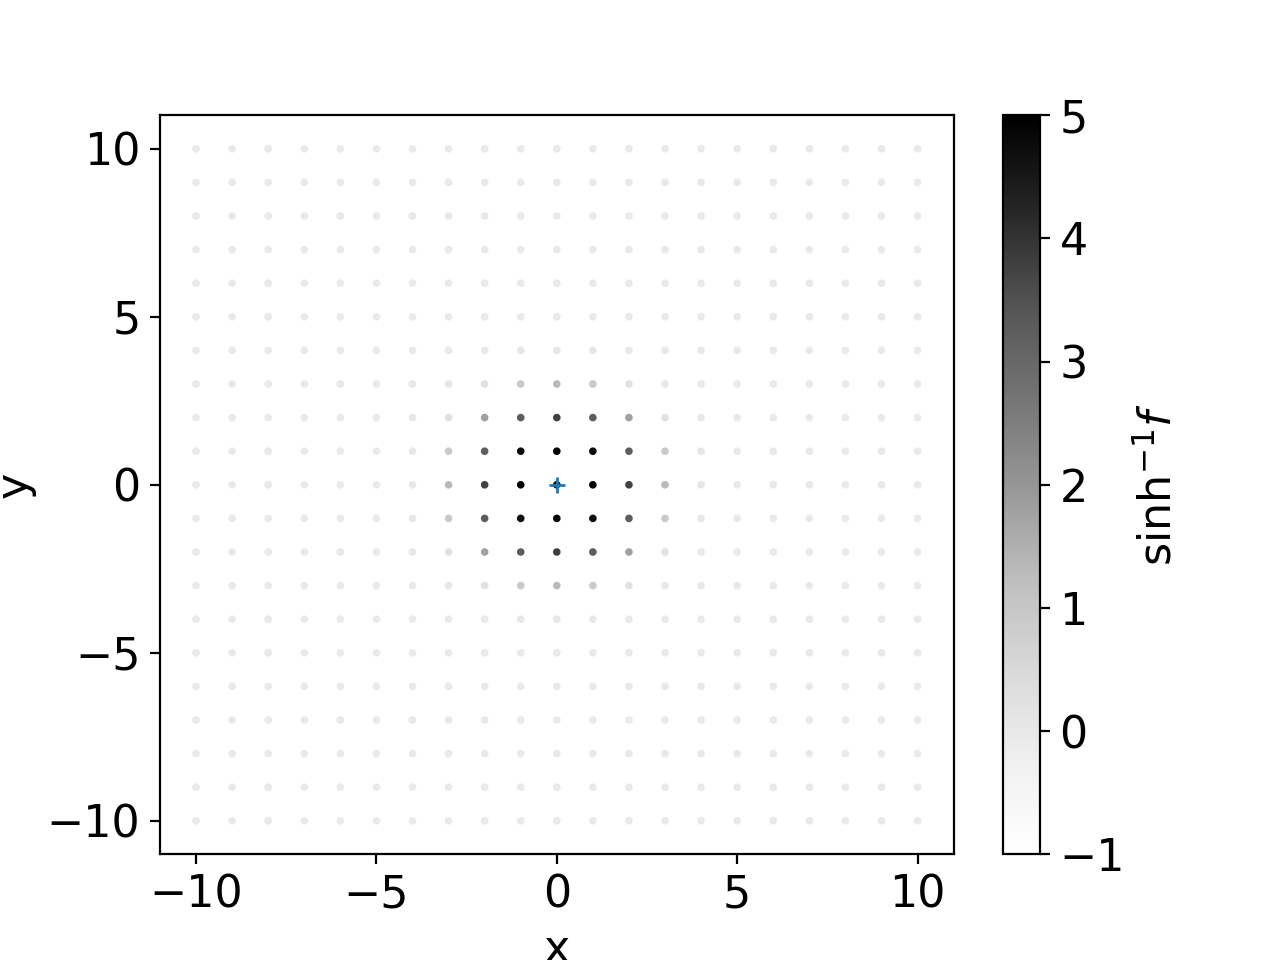

In [7]:
sampling = SamplingRect()
sampling.set_flux(total_flux=1000., noise=1.e-3)
sampling.imshow()
plt.savefig('../tex/figures/rectilinear-data.png', dpi=300)

### Shepard's method

A classic method in this situation is Shepard's method, which uses a radial function to assign weights to points on the desired grid. We define:

 * The vector of samples $\vec{f}$, of length $N$,
 * An image $\vec{S}$, the set of values resulting from Shepard's procedure
 
The image is determined by:

$$\vec{S} = \mathbf{W}\cdot \vec{f}$$
 
where the weights are:

$$W_{ij} = 
  \frac{1}{W_{0,i}}\exp\left(-\frac{r_{ij}^2}{2\sigma_0^2}\right)$$
  
for $r_{ij} < r_{\rm lim}$, and zero otherwise. 
$W_{0, i}$ is
defined as the sum of the $N$ weights for each output grid point $i$,
to guarantee the conservation of flux:
$$W_{0, i} =\sum_{j}\exp\left(-\frac{r_{ij}^2}{2 \sigma_0^2}\right)$$



We will first set up the desired output grid. We choose a pixel sampling of about 1 unit of distance, since the smallest FWHM of the kernel is a little bigger than 2 units of distance.

We will calculate weights using $\sigma_0 = 0.75$.

In [5]:
sigma0 = 0.75
W_S = np.zeros((nx * ny, sampling.nsamples))
for j in np.arange(sampling.nsamples):
    rij2 = (xgrid - sampling.x[j])**2 + (ygrid - sampling.y[j])**2
    W_S[:, j] = np.exp(- 0.5 * rij2 / sigma0**2)
for i in np.arange(nx * ny):
    W_S[i, :] = W_S[i, :] / W_S[i, :].sum()

In [6]:
S_S = W_S.dot(sampling.flux).reshape(nx, ny)

<IPython.core.display.Javascript object>


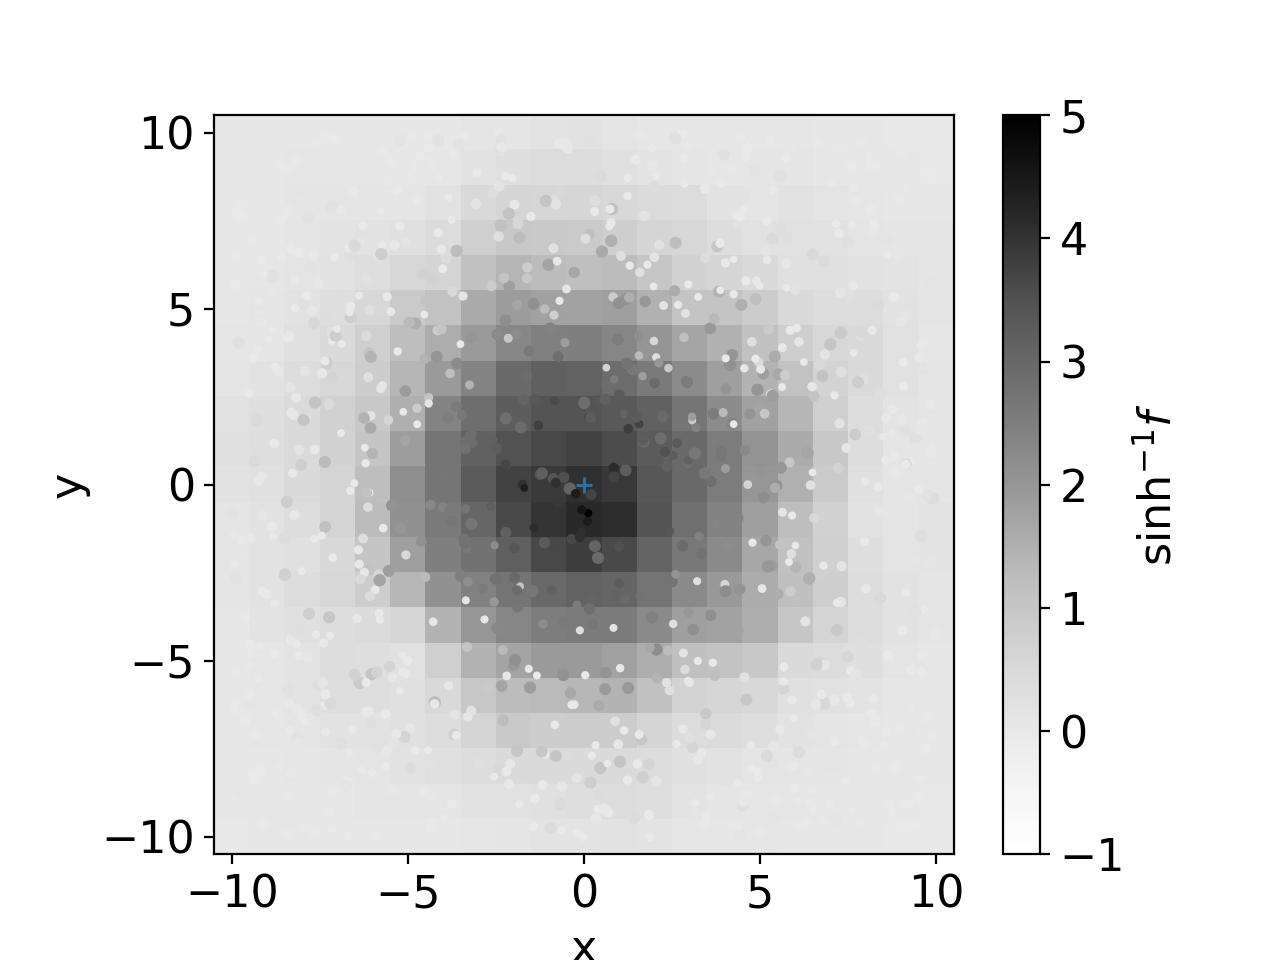

In [7]:
sampling.imshow(S_S)
plt.savefig('../tex/figures/scattered-shepard.png', dpi=300)

### Modelling the image

Relevant to some, though not all, methods of interpolation of scattered data is the idea of a model image that explains our sampled fluxes. To do so, we will define:

 * The vector of samples $\vec{f}$, of length $N$,
 * A model image $\vec{F}$, which represents a regular grid of delta functions, with a total of $M$ grid points, and
 * The kernel transformation ${\mathbf A}$, an $N\times M$ matrix.

The kernel transformation defines how each sample responds to the delta function in the model image. We can build it with successive calls to the code that generates the fluxes. Under these definitions a model $\vec{m}$ can be written as:

$$\vec{m} = {\mathbf A} \cdot \vec{f}$$

Once we have ${\mathbf A}$ we can fit the parameters in the model image $\vec{F}$.  We minimize:

$$\chi^2 = \left(\vec{m} - \vec{f}\right)\cdot {\mathbf N}^{-1} \cdot \left(\vec{m} - \vec{f}\right)$$

To find the values of $\vec{F}$ minimize $\chi^2$, we apply singular value decomposition as follows:

$${\mathbf N}^{1/2} {\mathbf A} = {\mathbf U} \cdot \Sigma \cdot {\mathbf V}^T$$

That makes the inversion of the problem easy so it is:

$$\vec{F} = {\mathbf V}\cdot\Sigma \cdot {\mathbf U}^T \cdot {\mathbf N}^{-1/2} \cdot \vec{f} $$

The covariance of this image can be calculated as:

$${\mathbf C}_F^{-1} = {\mathbf A}^T\cdot{\mathbf N}^{-1}\cdot{\mathbf A}$$


In [8]:
M = len(ygrid)
A = np.zeros((sampling.nsamples, M))
for i in np.arange(M):
    f = sampling.fluxes(xcen=xgrid[i], ycen=ygrid[i])
    A[:, i] = f.flatten()

We can create a noiseless image and perform the fit. This works great. It is very closely equivalent to a full image deconvolution.

In [9]:
(U, S, VT) = np.linalg.svd(A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv[S > 0] = 1. / S[S > 0] 
W_F = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_F = W_F.dot(sampling.flux_nonoise)
S_F = S_F.reshape((nx, ny))

<IPython.core.display.Javascript object>


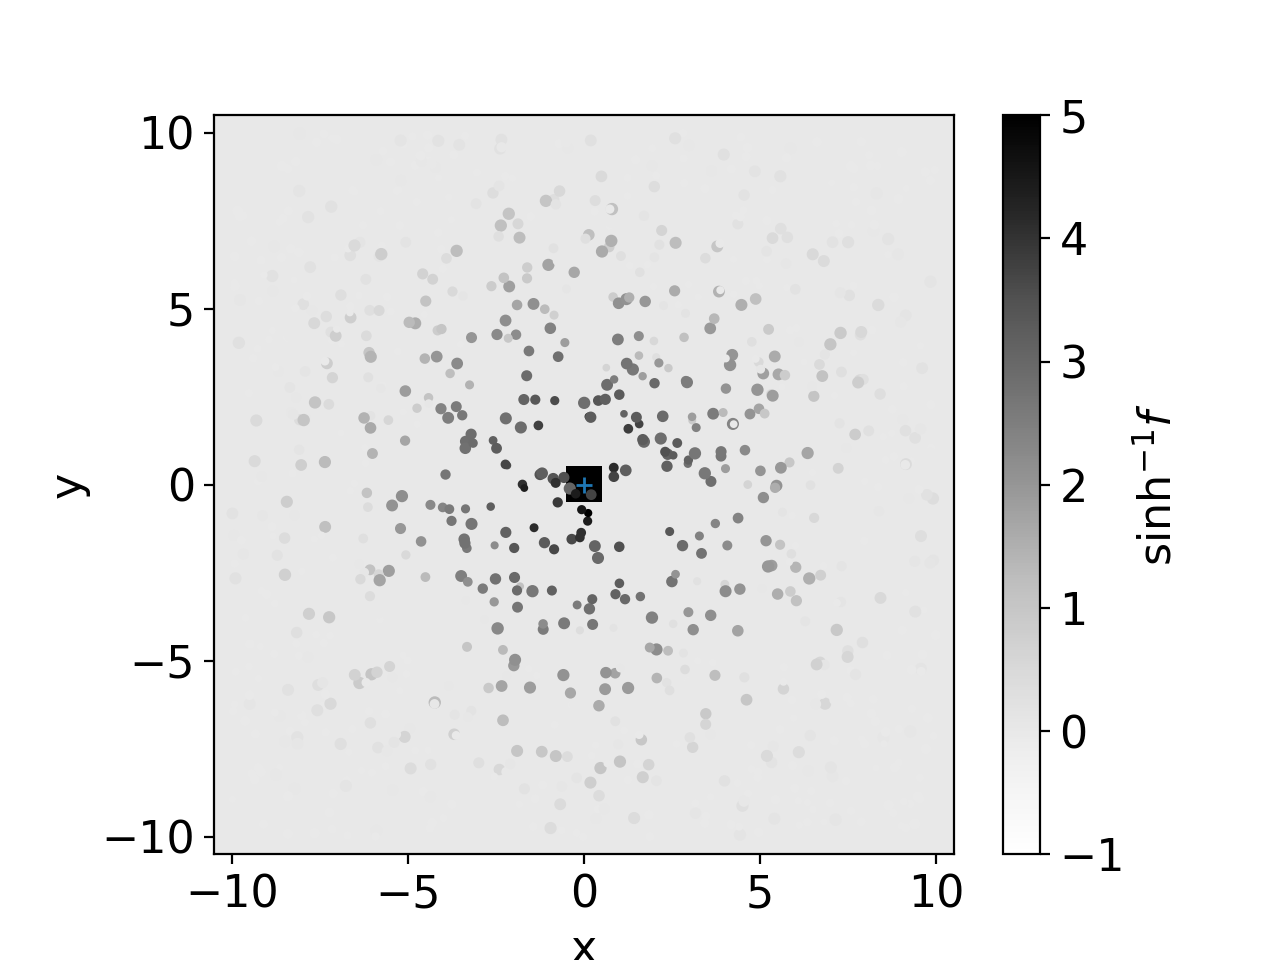

In [10]:
sampling.imshow(S_F)
plt.savefig('../tex/figures/scattered-unregularized-noiseless.png', dpi=300)

But if we add even a tiny amount of noise this runs into terrible trouble. Even $10^{-8}$ level noise leads to a very troublesome covariance matrix, which leads to strong fluctuations.

In [11]:
sampling.set_flux(total_flux=1000., noise=1.e-3)
S_F = W_F.dot(sampling.flux)
S_F = S_F.reshape((nx, ny))

<IPython.core.display.Javascript object>


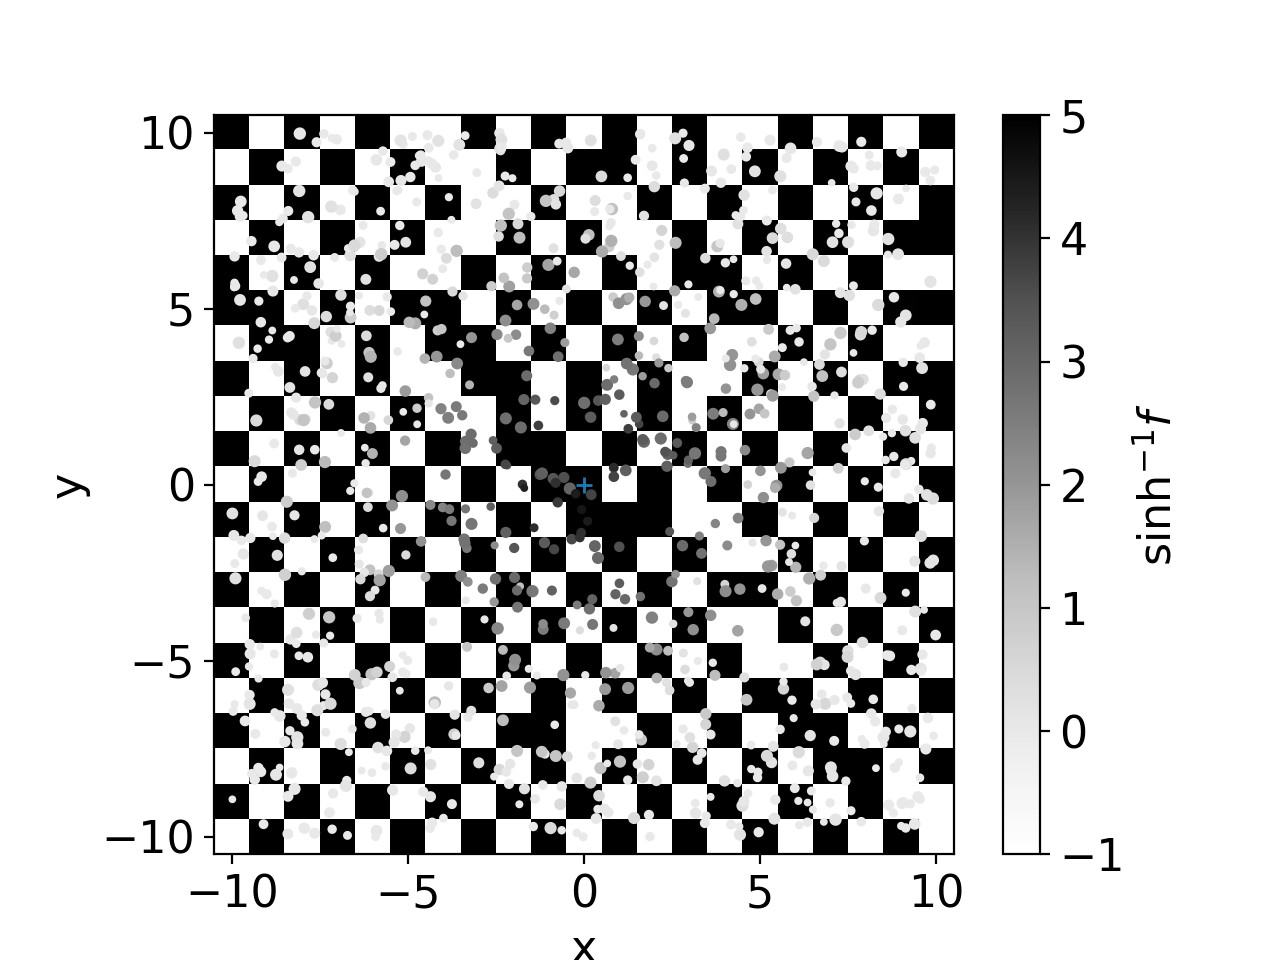

In [12]:
sampling.imshow(S_F)
plt.savefig('../tex/figures/scattered-unregularized-noisy.png', dpi=300)

The covariance matrix of this result can be calculated and clearly shows these issues.

<IPython.core.display.Javascript object>


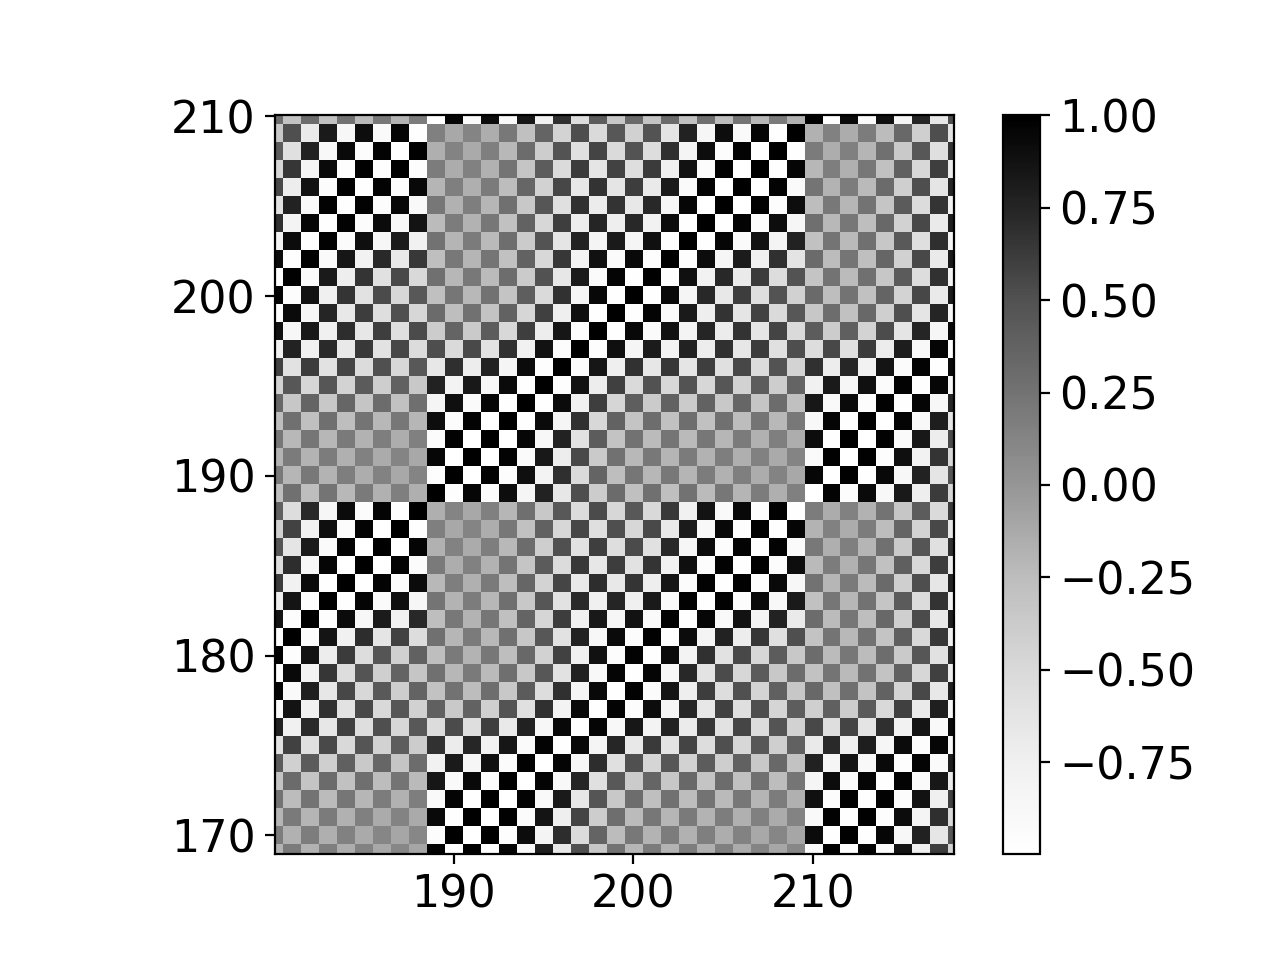

In [15]:
C_F = W_F.dot(W_F.T)
myargs = {'interpolation': 'nearest', 'origin': 'lower', 'cmap': cm.Greys}
CC_F = 0. * C_F
for i in np.arange(nx * ny):
    for j in np.arange(nx * ny):
        CC_F[i, j] = C_F[i, j] / np.sqrt(C_F[i, i] * C_F[j, j])
plt.imshow(CC_F, **myargs)
plt.colorbar()

A very common approach to handling these issues is to regularize the fit. The simplest form of regularization is Tikhonov regularization. In its simplest form, it is designed to quadratically favor reconstruction values near zero. This case simply reduces to a conversion of the singular values that causes their inverse to smoothly go to zero below a value of $\Sigma \sim \lambda$. We can ask what this does, in the case of noise and no noise. The noiseless case is very enlightening. The PSF of this method is extremely irregular even for small values of $\lambda$.

In [16]:
llambda = 3.e-3
(U, S, VT) = np.linalg.svd(A, full_matrices=False)
Sinv = np.zeros(len(S))
Sinv = S / (S**2 + llambda**2)
W_Ts = VT.T.dot(np.diag(Sinv)).dot(U.T)
S_Ts = W_Ts.dot(sampling.flux)
S_Ts = S_Ts.reshape((nx, ny))

<IPython.core.display.Javascript object>


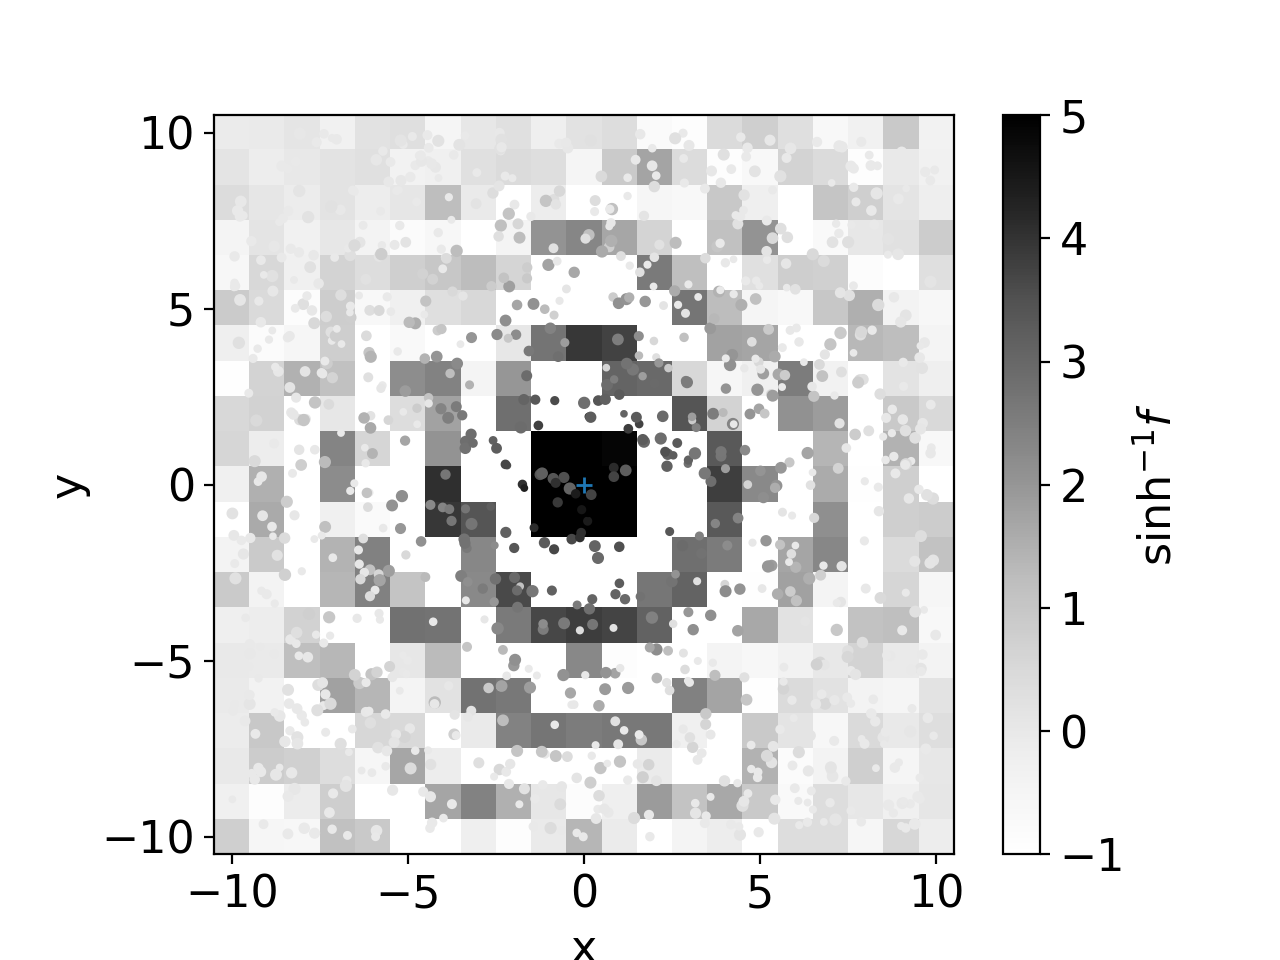

In [17]:
sampling.imshow(S_Ts)
plt.savefig('../tex/figures/scattered-regularized-simple-noisy.png', dpi=300)

In [18]:
S_Ts = W_Ts.dot(sampling.flux_nonoise)
S_Ts = S_Ts.reshape((nx, ny))

<IPython.core.display.Javascript object>


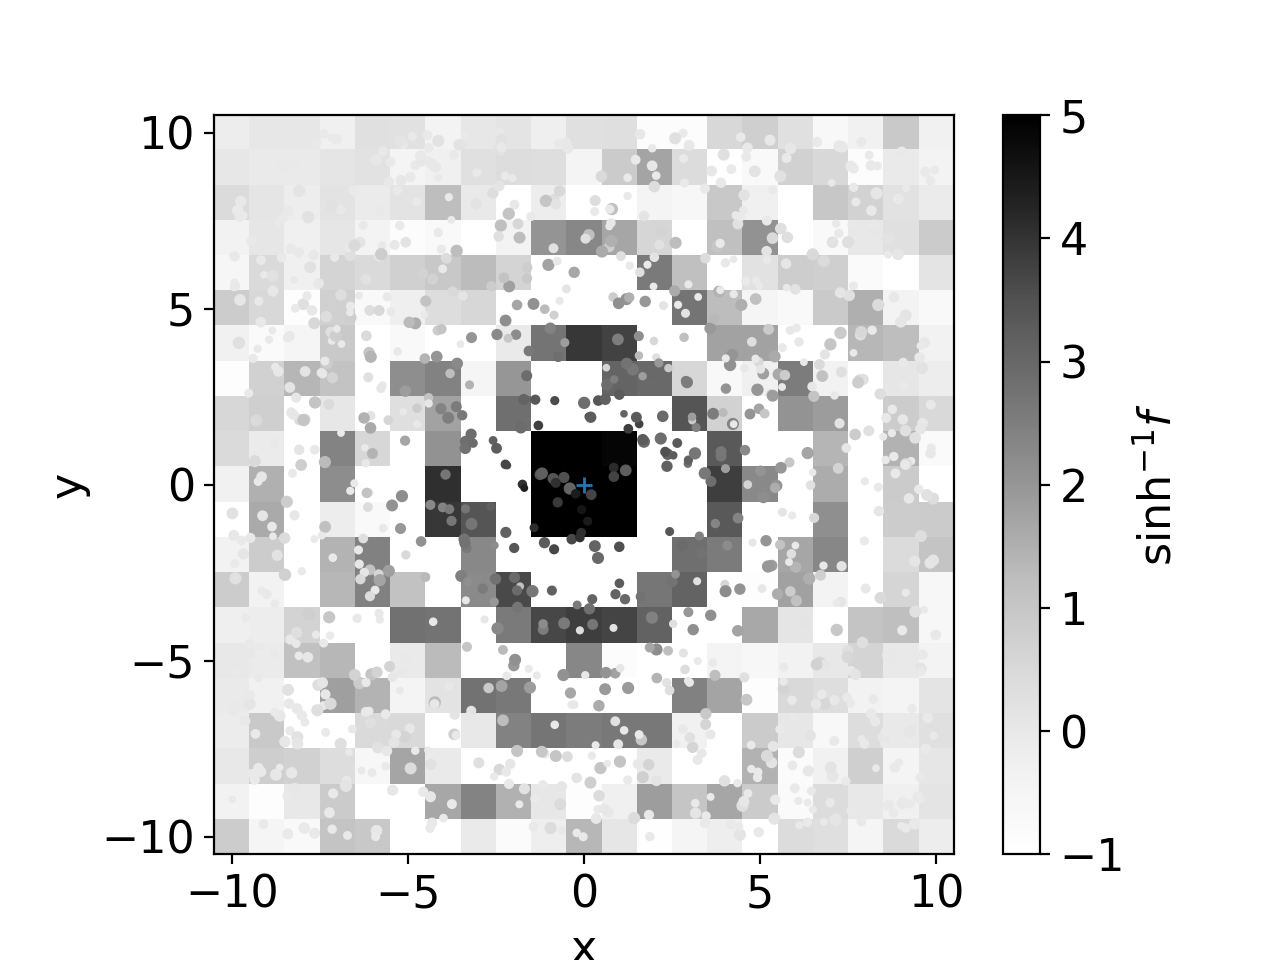

In [19]:
sampling.imshow(S_Ts)
plt.savefig('../tex/figures/scattered-regularized-simple-noiseless.png', dpi=300)

There are more complicated ways of regularizing even in the Tikhonov case. In particular, one can construct $\Gamma$ to favor minimizing the squared differences of neighboring pixels. We can solve this problem using generalized SVD. First we will test that it works on the simplest Tikhonov case. It matches perfectly.

In [20]:
N = nx * ny
Gamma = np.diag(np.ones(N))
(sigma1_gs, sigma2_gs, X_gs, U_gs, V_gs) = pygsvd.gsvd(A, Gamma, extras='uv')

In [21]:
XTinv_gs = np.linalg.inv(X_gs.T)

In [22]:
llambda = 3.e-3
sigmat_gs = np.diag(1. / (sigma1_gs * sigma1_gs + llambda**2 * sigma2_gs * sigma2_gs))
W_Tgs = XTinv_gs.dot(sigmat_gs).dot(np.diag(sigma1_gs)).dot(U_gs.T)

In [23]:
S_Tgs = W_Tgs.dot(sampling.flux_nonoise)
S_Tgs = S_Tgs.reshape((nx, ny))

<IPython.core.display.Javascript object>


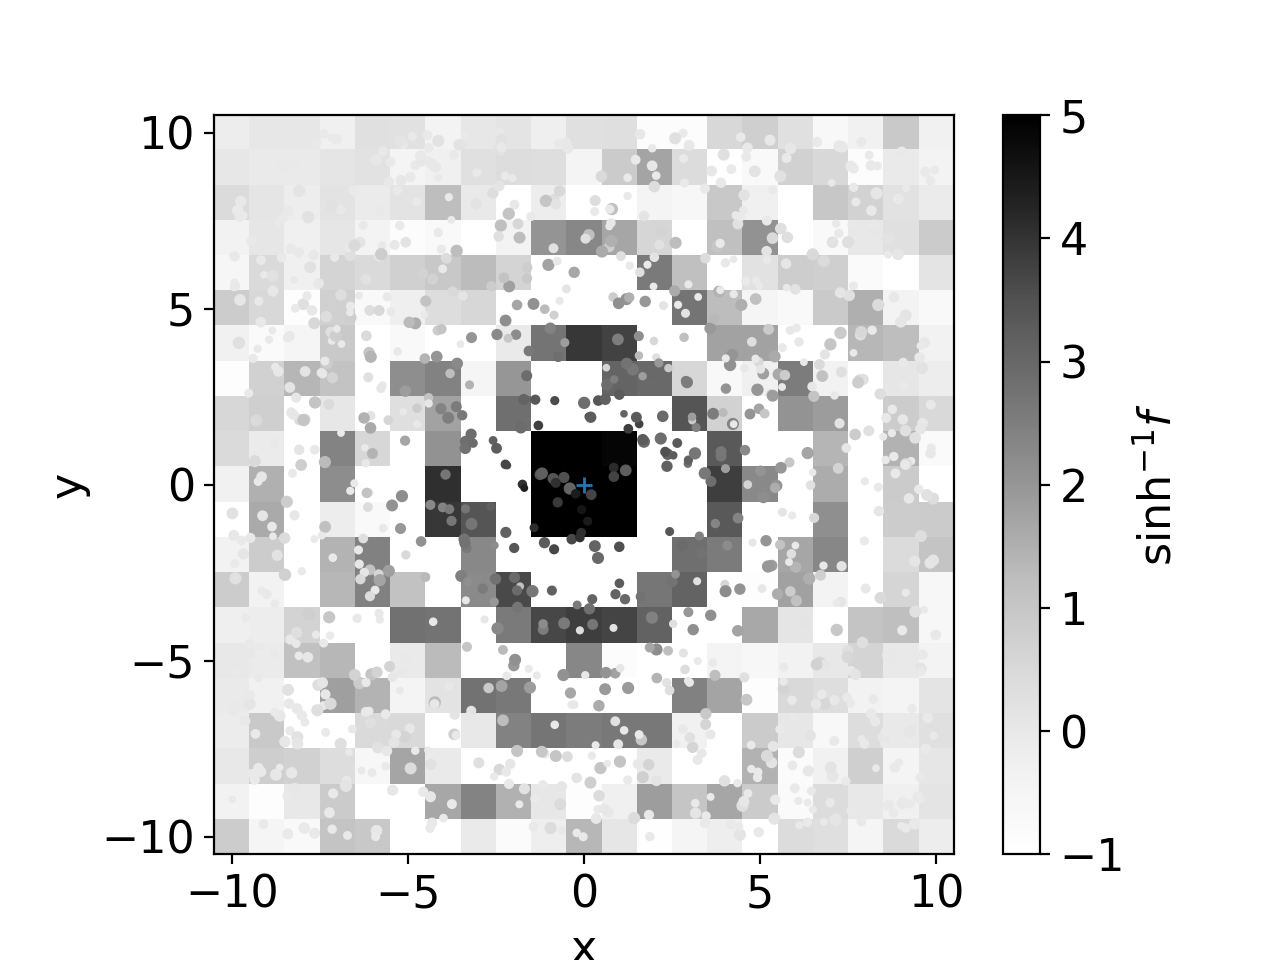

In [24]:
sampling.imshow(S_Tgs)
plt.savefig('../tex/figures/scattered-regularized-Tsimple-noiseless.png', dpi=300)

Now we construct $\Gamma$ that minimizes the squared error between neighboring pixels. This is somewhat different but also shows that the PSF for this case is a complicated beast with a lot of ringing.

In [25]:
nx = 21
ny = 21
Gamma = np.zeros((nx * ny, nx * ny))
ident = np.diag(np.ones(nx * ny)).reshape(nx, ny, nx, ny)
sident = - roll_zeropad(ident, -1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, 1, axis=2)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, -1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
sident = - roll_zeropad(ident, 1, axis=3)
Gamma = Gamma + sident.reshape(nx * ny, nx * ny)
for indx in np.arange(nx * ny):
    Gammasum = - Gamma[indx, :].sum()
    Gamma[indx, :] = Gamma[indx, :] / Gammasum
    Gamma[indx, indx] = 1.

In [26]:
(sigma1_g, sigma2_g, X_g, U_g, V_g) = pygsvd.gsvd(A, Gamma, extras='uv')

In [27]:
XTinv_g = np.linalg.inv(X_g.T)

In [28]:
llambda = 3.e-3
sigmat_g = np.diag(1. / (sigma1_g * sigma1_g + llambda**2 * sigma2_g * sigma2_g))
W_Tg = XTinv_g.dot(sigmat_g).dot(np.diag(sigma1_g)).dot(U_g.T)

In [29]:
S_Tg = W_Tg.dot(sampling.flux_nonoise)
S_Tg = S_Tg.reshape((nx, ny))

<IPython.core.display.Javascript object>


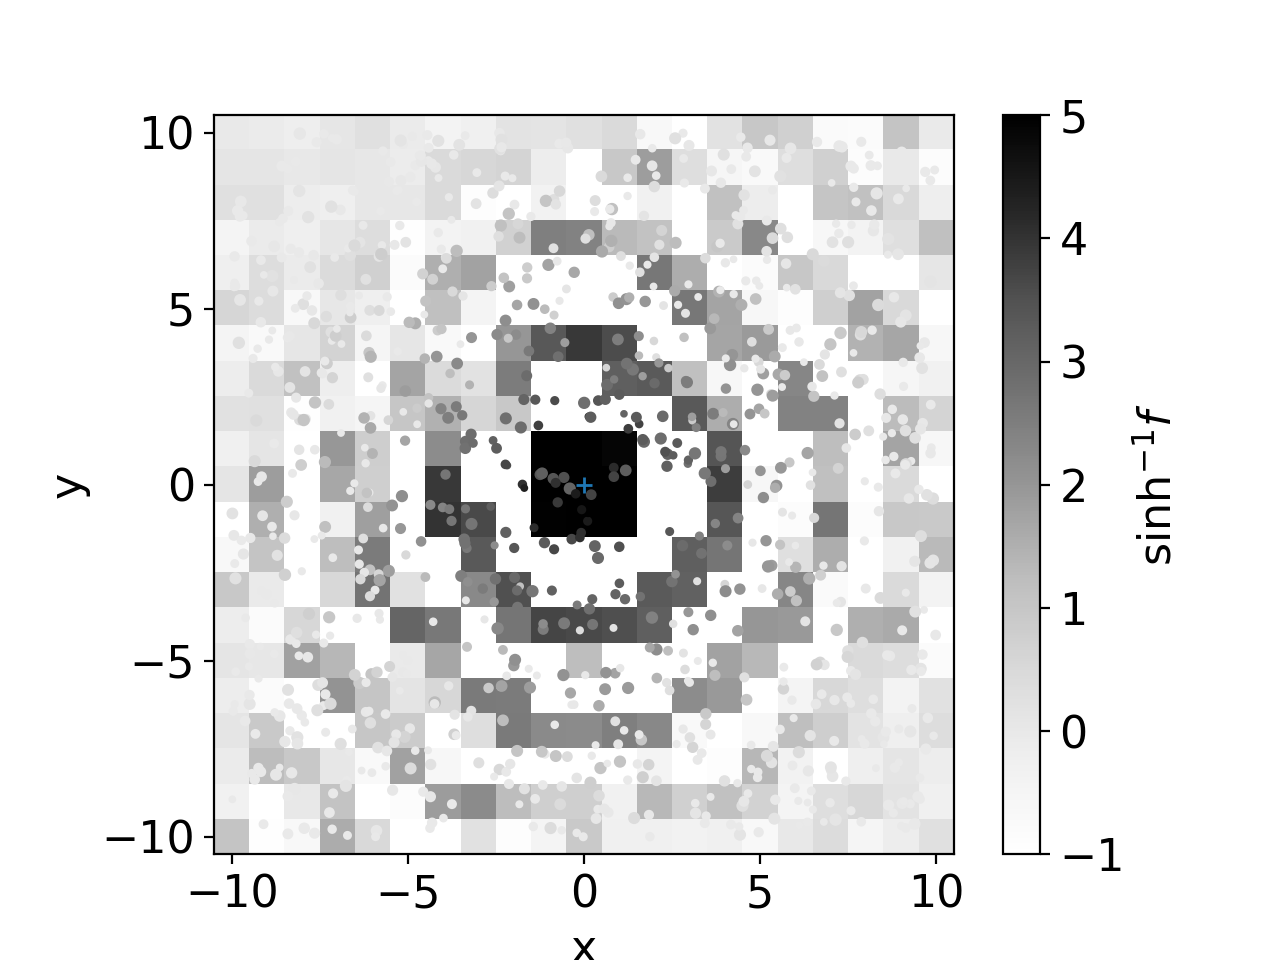

In [30]:
sampling.imshow(S_Tg)
plt.savefig('../tex/figures/scattered-regularized-T-noiseless.png', dpi=300)

In [31]:
S_Tg = W_Tg.dot(sampling.flux)
S_Tg = S_Tg.reshape((nx, ny))

<IPython.core.display.Javascript object>


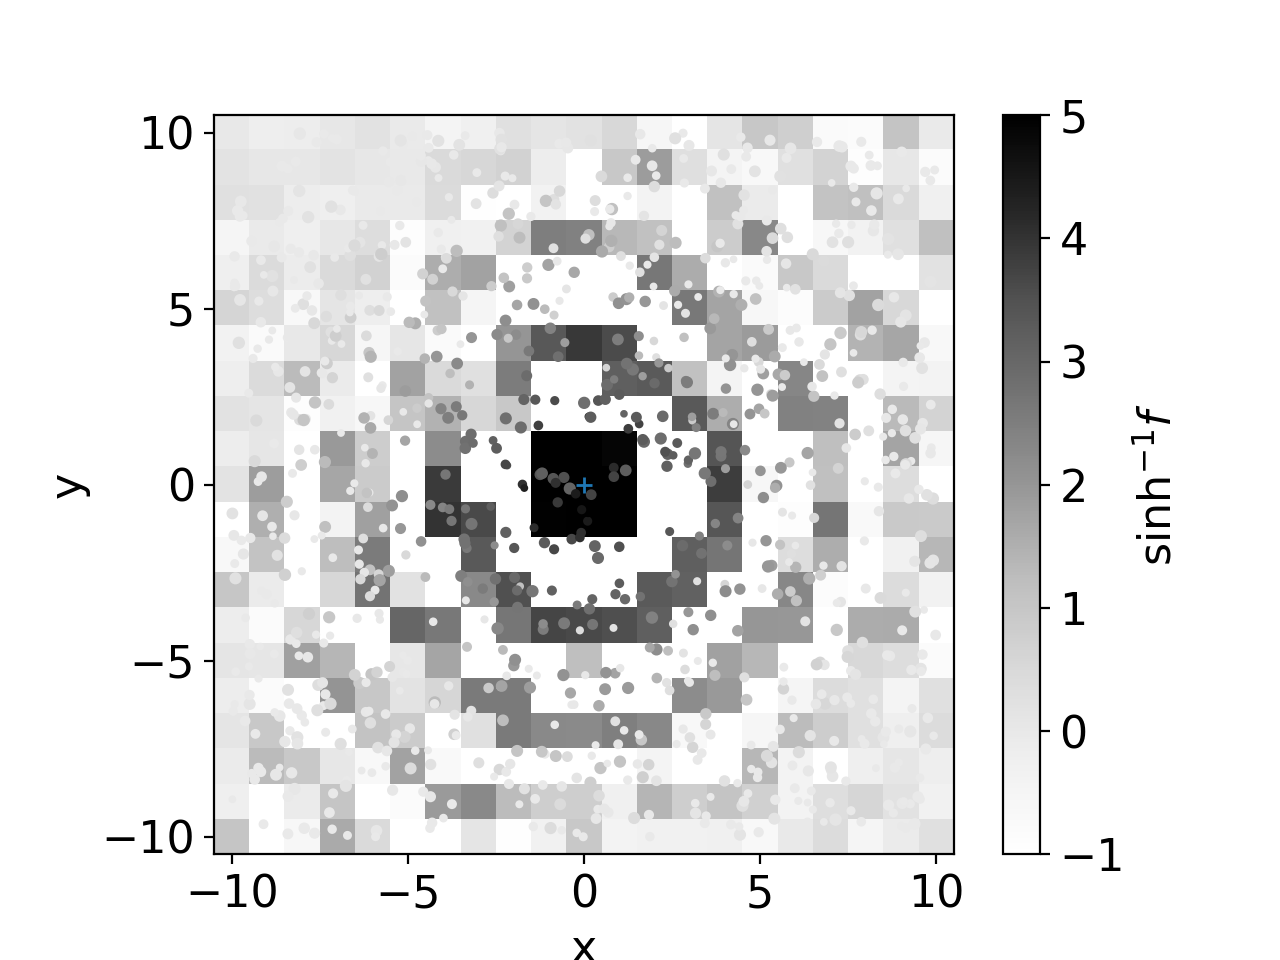

In [32]:
sampling.imshow(S_Tg)
plt.savefig('../tex/figures/scattered-regularized-T-noisy.png', dpi=300)

## Modelling the image with nonnegative constraints

The linear problem can be solved with non-negative constraints. This choice regularizes much of the bad behavior. With no noise, the result is completely unchanged from the linear fit. Note that in this case, this result cannot be interpreted exactly as the "PSF" because the method is not linear.

In [47]:
sampling.set_flux(total_flux=1000., noise=1.)

<IPython.core.display.Javascript object>


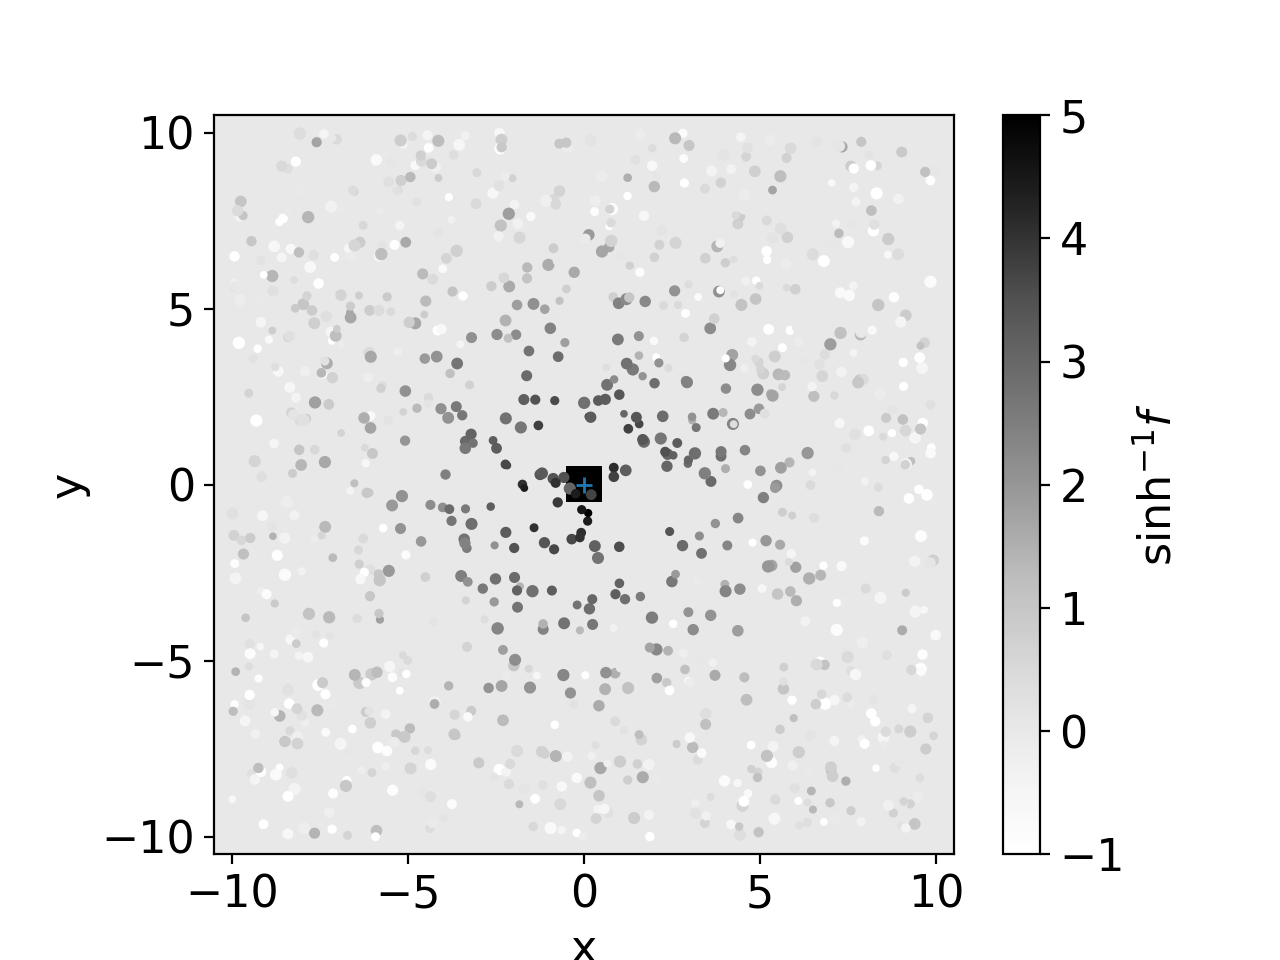

In [48]:
x = optimize.nnls(A, sampling.flux_nonoise)
S_FF = x[0].reshape(nx, ny)
sampling.imshow(S_FF)

But with noise, it still behaves pretty well! Noise spikes draw some points upwards. We expect that there will be some issues with bias of a measurement of an image derived from this method, however. For example, its total flux will be biased high. 

<IPython.core.display.Javascript object>


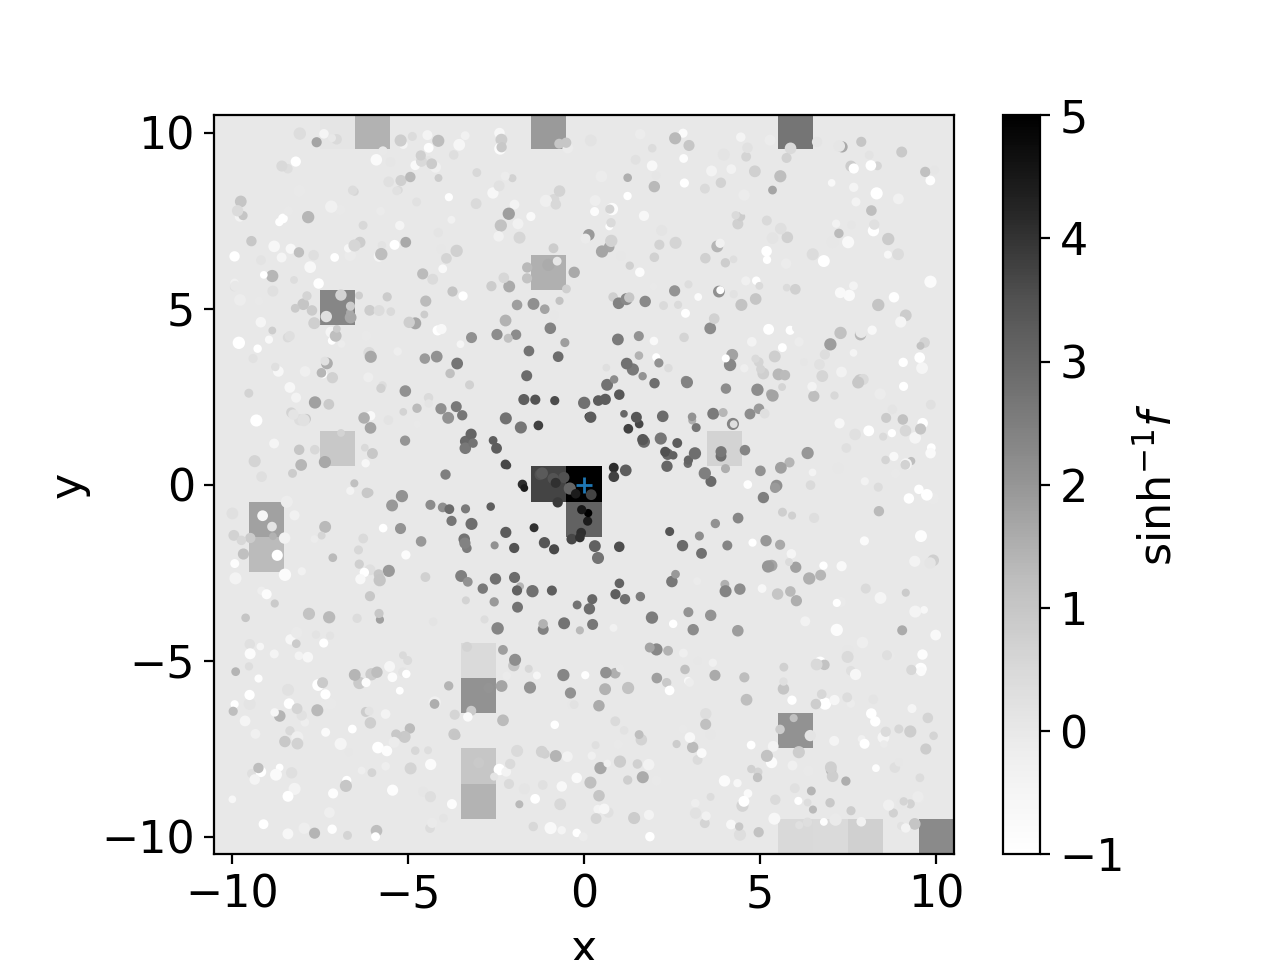

In [50]:
x = optimize.nnls(A, sampling.flux)
S_FF = x[0].reshape(nx, ny)
sampling.imshow(S_FF)

In [118]:
import scipy.sparse as sparse
import sparsesvd

class Reconstruct(object):
    def __init__(self, fmin=1.e-10):
        self.fmin = fmin
        self.flag_low_coverage = 1
        self.flag_unconstrained = 2
        return
    
    def set_A(self, A=None):
        self.A = A
        self.N = self.A.shape[0] # number of samples
        self.M = self.A.shape[1] # number of reconstruction points
        self.flag = np.zeros(self.M, dtype=np.int32)
        return
    
    def set_Asparse(self):
        # Find very unconstrained reconstruction points
        Asumcol = self.A.sum(axis=0)
        ic = np.where(Asumcol < self.A.max() * self.fmin)[0]
        self.flag[ic] = np.bitwise_or(self.flag[ic], self.flag_low_coverage)
        
        # Set up trimmed version of A
        self.iAtrim = np.where(self.flag == 0)[0]
        Atrim = self.A[:, self.iAtrim]
       
        # Set explicitly to zero any very low contributions to a sample
        Amaxrow = Atrim.max(axis=1)
        for irow in np.arange(self.N, dtype=np.int32):
            ilow = np.where(Atrim[irow, :] < Amaxrow[irow] * self.fmin)[0]
            Atrim[irow, ilow] = 0.
        
        self.Asparse = sparse.csc_matrix(Atrim, dtype=np.float64)
        return
    
    def set_weights(self):
        (UT, S, VT) = sparsesvd.sparsesvd(self.Asparse, self.M)
        
        iSzero = np.where(S < S.max() * self.fmin)[0]
        self.iSnotzero = np.where(S >= S.max() * self.fmin)[0]
        self.flag[iSzero] = self.flag_unconstrained
        
        Snotzero = S[self.iSnotzero]
        Q = VT.T[:, self.iSnotzero].dot(np.diag(Snotzero)).dot(UT[self.iSnotzero, :])
        Qs = Q.sum(axis=1)
        self.Wc = np.diag(1. / Qs).dot(VT.T[:, self.iSnotzero]).dot(UT[self.iSnotzero, :])
        return
    
    def apply_weights(self, samples=None):
        pixels = np.zeros(self.M, dtype=np.float64)
        pixels[self.iAtrim] = self.Wc.dot(samples)
        return(pixels)
        

In [119]:
r = Reconstruct()
r.set_A(A=A)
r.set_Asparse()

In [120]:
r.set_weights()

In [122]:
pix = r.apply_weights(samples=sampling.flux_nonoise)

<IPython.core.display.Javascript object>


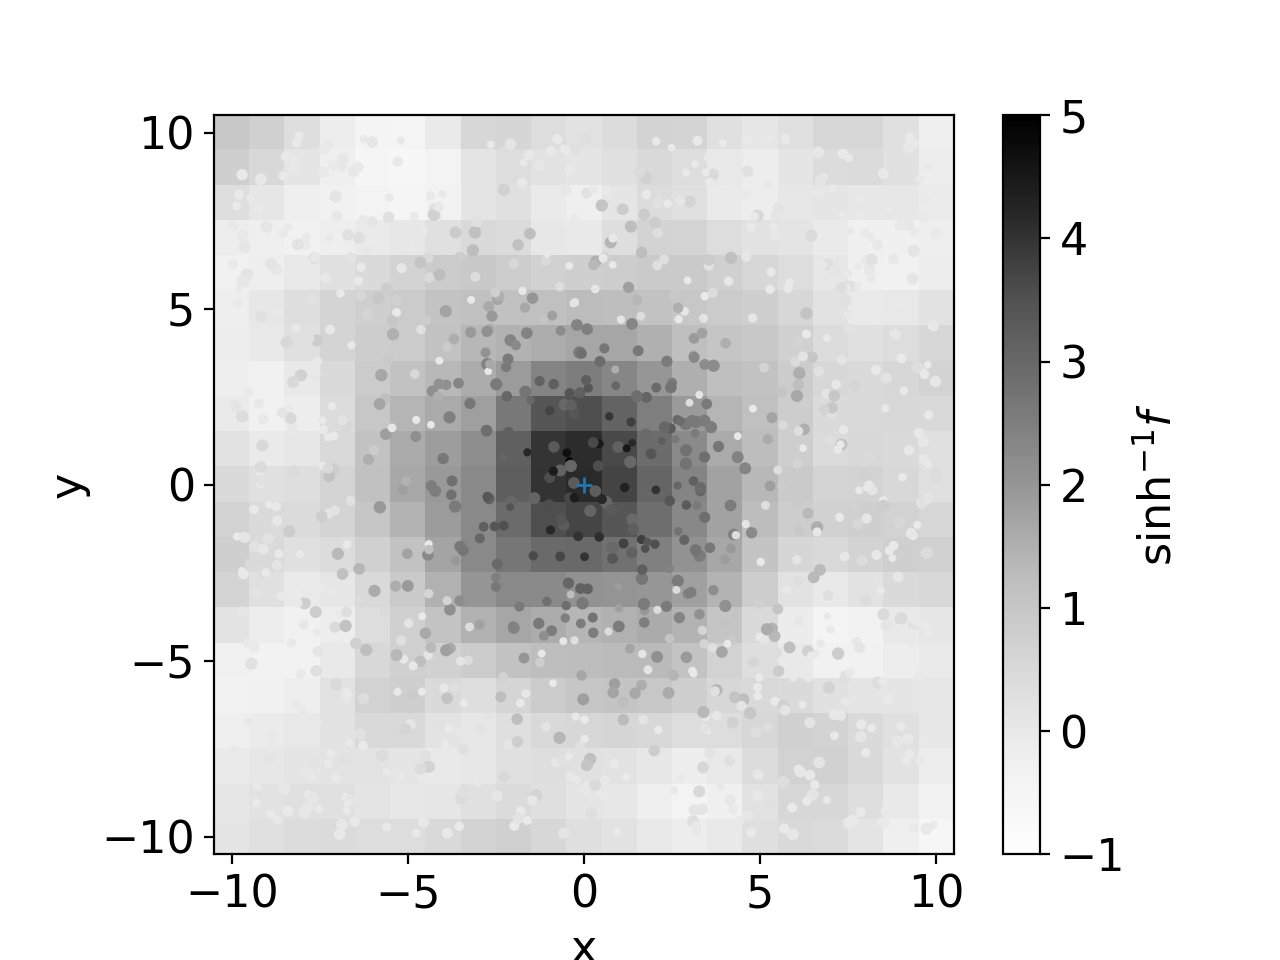

In [123]:
pixshow = pix.reshape(nx, ny)
sampling.imshow(pixshow)
plt.savefig('../tex/figures/scattered-G-noisy.png', dpi=300)

<IPython.core.display.Javascript object>


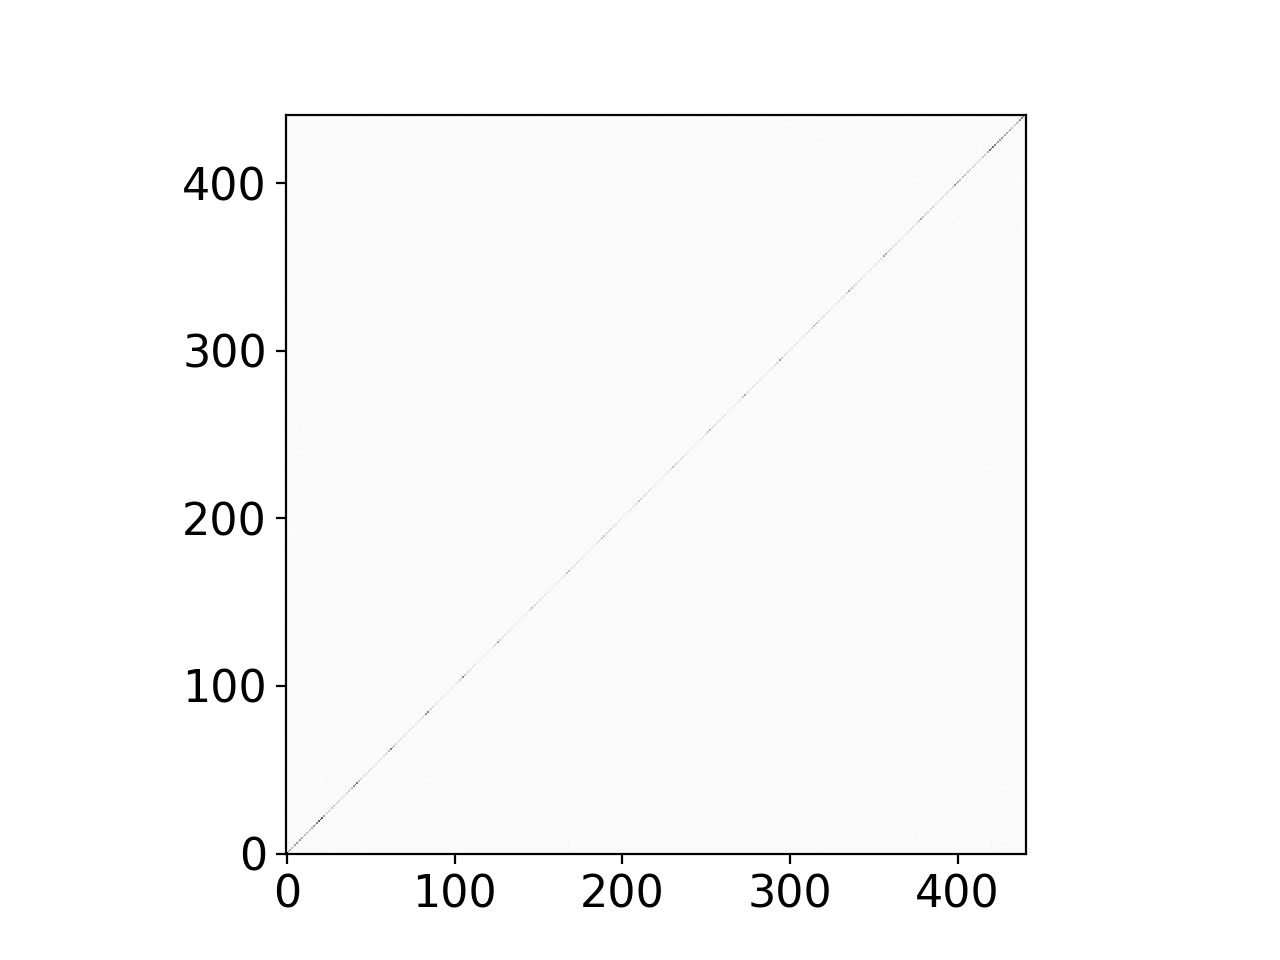

In [124]:
C = r.Wc.dot(r.Wc.T)
plt.imshow(np.arcsinh(C), **myargs)

In [88]:
print(A.shape)

(50, 441)


### Richardson-Lucy 

Richardson-Lucy deconvolves by iterating on the following equations:

$$\vec{c}^{(k)} = \mathbf{A}\cdot \vec{S}_R^{(k)}$$

$$d^{(k)}_i = \frac{f_i}{c_i^{(k)}}$$

$${S}_{R,i}^{(k+1)} = {S}_{R,i}^{(k)} \left(\mathbf{A}^T \cdot \vec{d}^{(k)}\right)_i$$

In [1]:
sampling.set_flux(total_flux=1000., noise=1.)

NameError: name 'sampling' is not defined

In [71]:
flux = sampling.flux
flux_fit = flux.copy()
flux_fit[flux_fit <= 0] = 1.e-7
flux_fit = flux
# S_R = S_S.flatten()
S_R = np.ones(len(S_S.flatten()))
for i in np.arange(100000):
    c = A.dot(S_R)
    d = flux_fit / c
    S_R = S_R * (A.T.dot(d))
S_R = S_R.reshape((nx, ny))

<IPython.core.display.Javascript object>


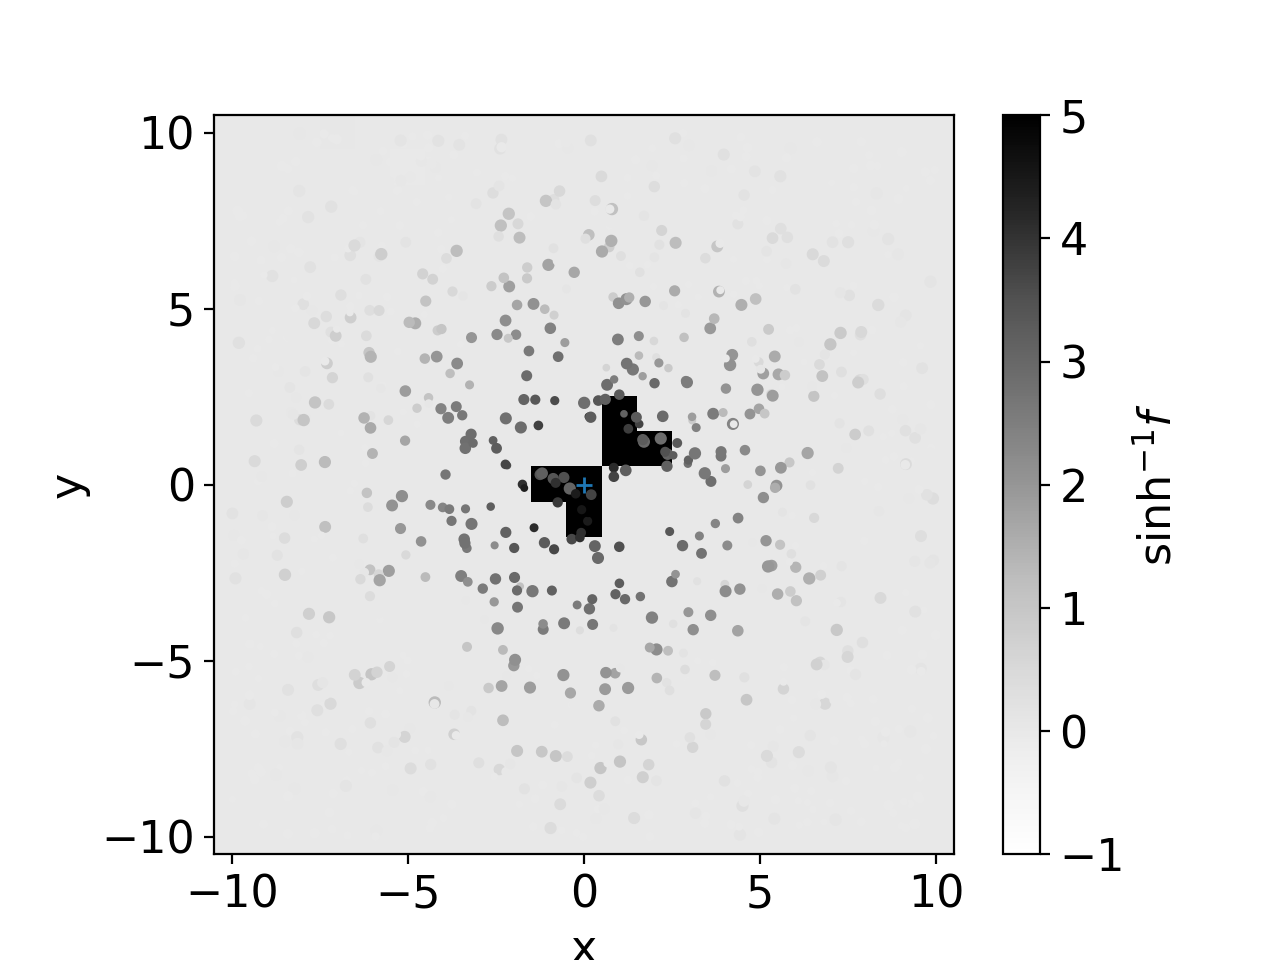

In [72]:
sampling.imshow(S_R)

In [390]:
import scipy.optimize as optimize

In [480]:
print(gg.sum())

166.66666666666669


In [563]:
import scipy.optimize as optimize

In [623]:
def mem_function(u, A, f, llambda):
    Ar = (A.dot(u) - f)
    As = (Ar**2).sum()
    Bs = (u * np.log(u)).sum()
    val =  As + llambda * Bs
    grad = 2. * A.T.dot(Ar) + llambda * (1. + np.log(u))
    return (val, grad)

In [643]:
llambda = 1.e-3
S_M0 = S_S.flatten()
S_M0[S_M0 <= 0.] = 1.e-3
bounds = zip([1.e-5] * len(S_M0), [None] * len(S_M0))
bounds = [x for x in bounds]

In [650]:
results = optimize.minimize(mem_function, S_M0, args=(A, flux, llambda), method='L-BFGS-B', jac=True,
                            bounds=bounds) 

In [651]:
S_M = results.x.reshape(nx, ny)

<IPython.core.display.Javascript object>


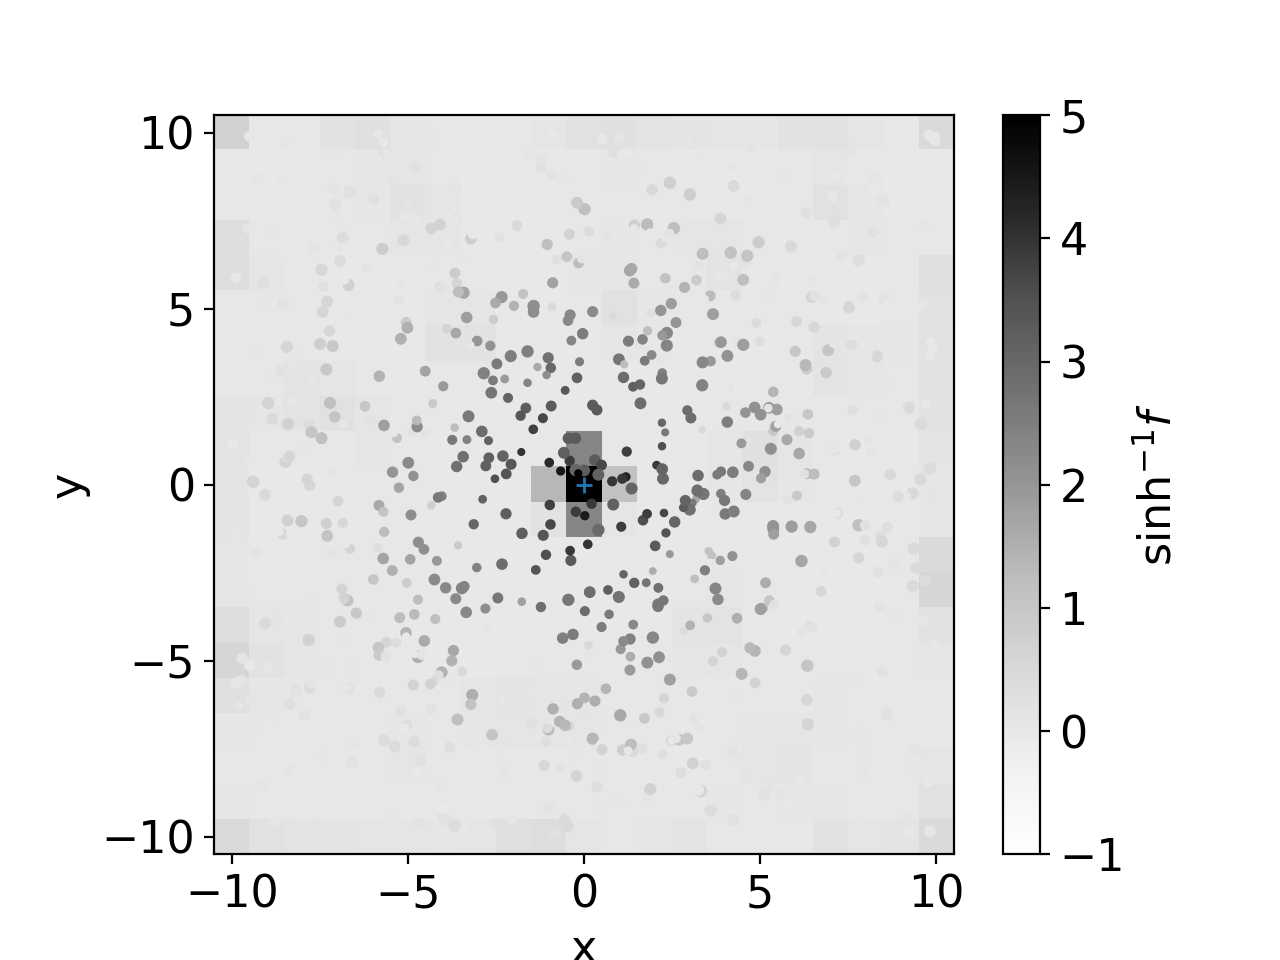

In [652]:
show_reconstruction(sampling, flux, S_M)

In [617]:
print(S_M.min())

1e-05


In [28]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T

# Observations
y = f(X).ravel()

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=10), n_restarts_optimizer=9,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)